# Water End-Use Disaggregation

In [11]:
# Importing the data 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
filepath= "/Users/Deeroo/Downloads/SayaData/University-18-31Oct.csv"
df= pd.read_csv(filepath, parse_dates=['Meter Local Time'], index_col= ['Meter Local Time'])
#preparing & cleaning the data 
df = df.sort_values(by=['Meter Local Time'])
#Replacing inaccurate data with 0 
df.loc[df.flow >500 , "flow"] = 0
df.head(5)


,Id,MeterNumber,flow,Flow Rate,Total Flow,CreatedDate
Meter Local Time,,,,,,
2022-10-18 02:38:00,8264,19240658,0.528,1.718,10287.650,10/18/22 6:38
2022-10-18 02:39:00,34616,19240551,0.000,0.000,21209.842,10/18/22 6:39
2022-10-18 02:39:00,9890,19240656,2.113,5.143,13885.145,10/18/22 6:39
2022-10-18 02:40:00,34617,19240551,0.000,0.072,21209.842,10/18/22 6:40
2022-10-18 02:40:00,34618,19240551,0.000,0.000,21209.842,10/18/22 6:40


### Feature Engineering

In [12]:
#First function: Data Resampling 
def Data_Resampling(df):
    
    df["MeterNumber"]= df["MeterNumber"].astype(str)
    Resampled = pd.DataFrame()

    MeterList= df.MeterNumber.unique()
    for i in MeterList: 

        x= df[df["MeterNumber"] == i] 
        Meter= x["MeterNumber"].resample('1T').max()
        Meter= Meter.fillna(i)

        Flow= x["flow"].resample('1T').sum()

        Resampled_Metere= pd.concat([Meter, Flow ], axis=1)
        Resampled= pd.concat([Resampled_Metere,Resampled], axis=0)
    
    return Resampled

In [13]:
#Second function: Feature Engineering (creating an event based df)
def feature_engineering1(data):
    
    data = data.sort_values(by=["MeterNumber" ,"Meter Local Time"])
    data['events'] = [ '1' if (x > 0)  else 0  for x in data['flow']]
    data['events']=data['events'].apply(pd.to_numeric)
    
    #feature engineering: event durations 
    d=0
    dur=[]
    for i in range(0 , len(data)):
        if(data['events'][i] !=0):
            d+=1
            dur.append(d)
        else:
            d=0
            dur.append(d)    
    data['Duration']= dur 
   
    
    #feature engineering: unique event IDs
    eid=100
    ID=[]
    for i in range(0 , len(data)):
        if(data['Duration'][i] == 1):
            eid+=1
            ID.append(eid)
        elif(data['Duration'][i] > 1):
            ID.append(eid)
        else: 
            ID.append(0) 
    data['UsageID']= ID
    #keeping the events only
    data= data[data["UsageID"] > 0] 
    
    
    #feature engineering: the time of the day(AM,PM)
    data['ToD']= data.index.strftime("%p")
    
    #feature engineering: a copy of the date  
    data['Meter Local Time']= data.index
    

    #feature engineering: the event event volume  
    volume= data.groupby(['UsageID'])[['flow']].sum()
    volume= volume.rename(columns={"flow":"Volume"})
    dur= data.groupby(['UsageID'])[['Duration']].max()
    dur= dur.rename(columns={"Duration":"Total Duration"})
    dur['Volume']= volume["Volume"]
    
    #feature engineering: the avg flowrate per event
    dur['EventFlowRate']= dur["Volume"]/ dur["Total Duration"] 
    

    data= dur.join(data.set_index('UsageID'), on='UsageID')
    data = data.sort_values(by="Meter Local Time")
    data= data.round(2)
    data= data.reset_index()
   
    
    return data[["Meter Local Time","MeterNumber","flow","UsageID","ToD", 'Total Duration', "Volume", "EventFlowRate"]]

In [30]:
#Third function: Feature Enginnerig (Adding more features for analytics)
def feature_engineering2(data):
    
    #creating new DF for events 
    # event total duration 
    TD= data.groupby(['UsageID'])[['Total Duration']].max() 
    TD= TD.reset_index()
    #event avg flow rate 
    AFR= data.groupby(['UsageID'])[['EventFlowRate']].max() 
    AFR= AFR.reset_index()
    EDF= TD.join(AFR.set_index('UsageID'), on='UsageID')
    # event water volume 
    Volume= data.groupby(['UsageID'])[['Volume']].max()
    Volume= Volume.reset_index()
    EDF= EDF.join(Volume.set_index('UsageID'), on='UsageID')
    #event time 
    ToD= data.groupby(['UsageID'])[['ToD']].agg(pd.Series.mode)
    ToD= ToD.reset_index() 
    EDF= EDF.join(ToD.set_index('UsageID'), on='UsageID')
    # event meter number 
    MN= data.groupby(['UsageID'])[['MeterNumber']].max()
    MN= MN.reset_index()
    EDF= EDF.join(MN.set_index('UsageID'), on='UsageID')
    # Event date 
    ED= data.groupby(['UsageID'])[['Meter Local Time']].min()
    ED= ED.reset_index()
    EDF= EDF.join(ED.set_index('UsageID'), on='UsageID')
    # Flow Type 
    HighFlowDF= EDF[(EDF['Total Duration'] >=2) & (EDF['Total Duration'] <= 4) &  (EDF['Volume'] >=50) &  (EDF['Volume'] <=55)]
    LowFlowDF= EDF[(EDF['Total Duration'] >=20) & (EDF['Total Duration'] <= 25) &  (EDF['Volume'] >=5) & (EDF['Volume'] <=7)]
    HighFlowID= list( HighFlowDF["UsageID"])
    LowFlowID= list(LowFlowDF['UsageID'] )
    FlowType=[]
    for i in range(0, len(EDF)):
        if ( EDF['UsageID'][i] in LowFlowID ) : 
            LowFlow= "LowFlow"
            FlowType.append(LowFlow)

        elif(  EDF['UsageID'][i] in HighFlowID  )  :
            HighFlow= "HighFlow" 
            FlowType.append(HighFlow)
        else:
            FlowType.append("NormalFlow")

    EDF["FlowType"] =   FlowType
    Date= EDF['Meter Local Time'].dt.day
    EDF["Date"]= Date
    Dayofweek= EDF['Meter Local Time'].dt.dayofweek
    EDF["Dayofweek"]= Dayofweek
    HourofDay= EDF['Meter Local Time'].dt.hour
    EDF["HourofDay"]= HourofDay
    EDF["HourofDay"]=EDF.HourofDay.replace(0,12)

    EDF= EDF.fillna(0)
    EDF= EDF.rename(columns={"Total Duration":"Duration"})
    
    return EDF





In [38]:
#Fourth function: Water End-Use Disaggregation
def Water_Disaggregation(New_data):
    WUC=[]
    #WashingMachine 
    WMF_Mini= 2.8   #WashingMachine minimum flow 
    WMF_Max = 6.6     #WashingMachine maximum flow
    WMD_Mini_d = 1   #WashingMachine minimum duration 
    WMD_Max_d  =  5   #WashingMachine maximium duration
    
    #Dishwasher
    DW_Mini= 0.7   #Dishwasher minimum flow 
    DW_Max = 2.6   #Dishwasher maximum flow
    DW_Mini_d = 1  #Dishwasher minimum duration 
    DW_Max_d  = 2  #Dishwasher maximium duration
    DW_FR_M= 0.37
    DW_FR_Ma=2.58
    
    #shower
    SF_Mini=  5.3   # shower minimum flow 
    SF_Max =  100   # shower maximum flow
    SD_Mini_d = 4   # Shower minimum duration 
    SD_Max_d  = 40  # Shower maximum duration 
    SFR= 1      # Event Minimum FlowRate 
    
    #Manual dishwashing
    MDW_Mini=   3      #  minimum manual dishwashing
    MDW_Max =    21    #  manual dishwashing 
    MDW_Mini_d= 1      #  minimum manual dishwashing duration
    MDW_Max_d =  7     #  maximum manual dishwashing duration
    
    #Toilet uses
    Toilet_Mini = 1.58   # Toilet  minimum flow
    Toilet_Max  =  2.2     # Toilet  maximum flow
    Toilet_Max_d =  2   # Toilet  maximum time
    
    #Sink uses
    Sink_Mini= 0.25   # Sink uses minimum flow
    Sink_Max =  5     # Sink uses maximum flow
    Sink_Mini_d= 1  # Sink uses minimum time
    Sink_Max_d =  5   # Sink uses maximum time
    Sink_FR_M= 0.2


    
    for i in range(0, len(New_data)):
        if ((New_data['Volume'][i] >= Toilet_Mini) & (New_data['Volume'][i] <= Toilet_Max) & (New_data['Duration'][i] <=  Toilet_Max_d ) ):
            WU='Toilet Flush'
            WUC.append(WU)
        elif  ((New_data['Volume'][i] >= DW_Mini) & (New_data['Volume'][i] <= DW_Max) & (New_data['Duration'][i] >=  DW_Mini_d) & (New_data['Duration'][i] <=  DW_Max_d) & (New_data['EventFlowRate'][i] >= DW_FR_M) & (New_data['EventFlowRate'][i] <= DW_FR_Ma) ):
            WU='Dishwasher'
            WUC.append(WU) 
        elif ((New_data['Volume'][i] >= SF_Mini) & (New_data['Volume'][i] <=SF_Max) & (New_data['Duration'][i] >= SD_Mini_d) & (New_data['Duration'][i] <= SD_Max_d) & (New_data['EventFlowRate'][i] >= SFR)  ):
            WU='Shower'
            WUC.append(WU)
        elif((New_data['Volume'][i] >= WMF_Mini) & (New_data['Volume'][i] <= WMF_Max) & (New_data['Duration'][i] >= WMD_Mini_d) & (New_data['Duration'][i] <=  WMD_Max_d) ):
            WU='Washing Machine'
            WUC.append(WU)
        elif ((New_data['Volume'][i] >= MDW_Mini) & (New_data['Volume'][i] <= MDW_Max) & (New_data['Duration'][i] >=  MDW_Mini_d) & (New_data['Duration'][i] <=  MDW_Max_d) ):
            WU='Manual Dishwashing'
            WUC.append(WU) 
        elif ((New_data['Volume'][i] >= Sink_Mini) & (New_data['Volume'][i] <=Sink_Max) & (New_data['Duration'][i] >= Sink_Mini_d) & (New_data['Duration'][i] <=  Sink_Max_d) & (  New_data['EventFlowRate'][i]  >= Sink_FR_M) ):
            WU='Faucet'
            WUC.append(WU)
       
        else:
            WU="Other Uses"
            WUC.append(WU)

    #adding the usages to the data
    #Test 5: ensuring that there are no missing water uses 
    assert  len(New_data) == len(WUC) , "There are missing water uses"
    
    New_data['Disaggregation']= WUC

    return New_data['Disaggregation'].value_counts() 




In [ ]:
# Resampling the data 
Resampled_Data= Data_Resampling(df)
# Feature engineering 
data= feature_engineering1(Resampled_Data)
# Feature engineering2 
EDF= feature_engineering2(data)
#Water Disaggregation Function
Disaggregation=Water_Disaggregation(EDF)
Disaggregation

### Data Visualization

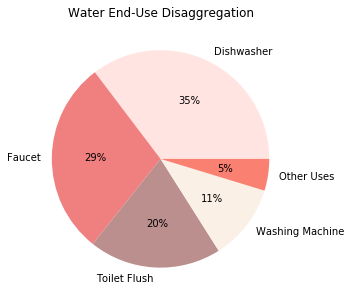

In [47]:
#Visualization The Results 
#Encoding the Disaggregation
EDF["Encode"]= [ 0 if (x == "Dishwasher")  else 1 if (x == "Faucet" ) else 2 if (x == "Toilet Flush")  else 3 if (x == "Washing Machine") else 4 for x in EDF['Disaggregation']]

plt.figure(figsize=(5, 5)) 
x= EDF["Encode"].value_counts()
values1= [ x[0],x[1], x[2],x[3],x[4]]
labels1= ['Dishwasher', 'Faucet', 'Toilet Flush',  'Washing Machine','Other Uses' ]
mycolors = ["mistyrose", "lightcoral","rosybrown","linen", "salmon", "sandybrown","darksalmon" ]
plt.pie(values1, labels = labels1 ,  colors = mycolors, autopct=lambda p: '{:.0f}%'.format(p) )
plt.title('Water End-Use Disaggregation')
plt.show() 


### Report Outputs 

In [63]:
#Disaggregation_Unit_Report
Disaggregation_Unit_Report= EDF.groupby(['MeterNumber',"Disaggregation" ])[['Volume']].sum()
#Disaggregation_Report2.to_excel('Regina15thFloor-May-Meter-Disaggregation.xlsx') 
Disaggregation_Unit_Report

Volume
MeterNumber Disaggregation            
19240443    Dishwasher          159.01
            Faucet               74.41
            Manual Dishwashing   77.13
            Other Uses           62.34
            Shower                5.55
...                                ...
20238153    Faucet               42.18
            Manual Dishwashing  101.96
            Other Uses            9.24
            Toilet Flush        136.97
            Washing Machine     127.55

[173 rows x 1 columns]

In [64]:
#Disaggregation Property_Report
Disaggregation_Report= EDF.groupby(["Disaggregation" ])[['Volume']].sum()
Disaggregation_Report = Disaggregation_Report.sort_values(by="Volume")
Disaggregation_Report= Disaggregation_Report.reset_index()
Disaggregation_Report2= EDF.groupby(["Disaggregation" ])[['UsageID']].count()
Disaggregation_Report2= Disaggregation_Report2.rename(columns={"UsageID":"Number of uses"})
Disaggregation_Report2= Disaggregation_Report2.reset_index()
Property_Report= Disaggregation_Report.join(Disaggregation_Report2.set_index('Disaggregation'), on='Disaggregation')
Property_Report= Property_Report.set_index("Disaggregation")
Property_Report= Property_Report.astype('int')
#Property_Report.to_excel('Regina10thFloor-May-Disaggregation.xlsx') 
Property_Report

,Volume,Number of uses
Disaggregation,,
Shower,996,108
Other Uses,1357,204
Faucet,2854,3937
Manual Dishwashing,2882,329
Toilet Flush,4733,2677
Washing Machine,6005,1536
Dishwasher,6178,4801


In [66]:
EDF

,UsageID,Duration,EventFlowRate,Volume,ToD,MeterNumber,Meter Local Time,FlowType,Date,Dayofweek,HourofDay,Disaggregation,Encode,DEncode
0,101,1,1.59,1.59,AM,19240443,2022-10-18 08:50:00,NormalFlow,18,1,8,Toilet Flush,2,1
1,102,1,0.26,0.26,AM,19240443,2022-10-18 09:29:00,NormalFlow,18,1,9,Faucet,1,1
2,103,4,1.39,5.55,AM,19240443,2022-10-18 11:39:00,NormalFlow,18,1,11,Shower,4,4
3,104,1,0.53,0.53,PM,19240443,2022-10-18 13:01:00,NormalFlow,18,1,13,Faucet,1,1
4,105,2,1.45,2.91,PM,19240443,2022-10-18 14:00:00,NormalFlow,18,1,14,Washing Machine,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,13688,1,0.66,0.66,PM,20238153,2022-10-31 19:44:00,NormalFlow,31,0,19,Faucet,1,1
13588,13689,1,2.26,2.26,PM,20238153,2022-10-31 20:28:00,NormalFlow,31,0,20,Dishwasher,0,1
13589,13690,1,0.00,0.00,PM,20238153,2022-10-31 20:51:00,NormalFlow,31,0,20,Other Uses,4,1
13590,13691,1,1.32,1.32,PM,20238153,2022-10-31 22:16:00,NormalFlow,31,0,22,Dishwasher,0,1
